# Assignment 1

### Group Members:

* Farhan Jamil
* Shoaib Huq
* Lerich Osay
* Sriram Sendhil

## Step 0: Importing Packages

In [ ]:
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import math

## Step 1: Data Loading and Preprocessing

In [16]:
def load_data(filepath):
    """
    Load data from a file and return a list of reviews.
    Each line in the file is a separate review.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        reviews = f.readlines()
    return reviews

def preprocess(text):
    """
    Preprocessing method:
    - Convert to lowercase
    - Handle punctuation better
    - Add start/end sentence markers
    """
    # Convert to lowercase
    text = text.lower()

    # Replace specific punctuation with spaces
    text = re.sub(r'[,.!?;:]', ' ', text)

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading/trailing whitespace
    text = text.strip()

    # Split by spaces to get tokens
    tokens = text.split()

    # Add sentence boundary markers
    tokens = ['<s>'] + tokens + ['</s>']

    return tokens

def preprocess_corpus(reviews):
    """Preprocess all reviews in the corpus"""
    all_tokens = []
    for review in reviews:
        tokens = preprocess(review)
        all_tokens.extend(tokens)
    return all_tokens

# Load and preprocess data
print("Loading and preprocessing data...")
train_path = 'train.txt'
validation_path = 'val.txt'

train_reviews = load_data(train_path)
train_tokens = preprocess_corpus(train_reviews)

validation_reviews = load_data(validation_path)
validation_tokens = preprocess_corpus(validation_reviews)

print("Some of the training set tokens:\t", train_tokens[:10])
print("Some of the validation set tokens:\t", validation_tokens[:10])

Loading and preprocessing data...
Some of the training set tokens:	 ['<s>', 'i', 'booked', 'two', 'rooms', 'four', 'months', 'in', 'advance', 'at']
Some of the validation set tokens:	 ['<s>', 'i', 'stayed', 'for', 'four', 'nights', 'while', 'attending', 'a', 'conference']


## Step 2: Vocabulary Building

In [17]:
def build_vocabulary(tokens, min_count=1):
    """
    Build vocabulary from tokens, optionally filtering by minimum count
    """
    word_counts = Counter(tokens)
    vocab = {word for word, count in word_counts.items() if count >= min_count}
    return vocab

print("Building vocabulary...")
vocab = build_vocabulary(train_tokens)
vocab_size = len(vocab)
print(f"Full vocabulary size: {vocab_size}")

Building vocabulary...
Full vocabulary size: 6257


## Step 3: Define Smoothing Methods

In [18]:
def laplace_smoothing(counts, vocab_size, context_counts=None):
    """Laplace (add-1) smoothing."""
    smoothed_probs = {}

    if context_counts is None:  # Unigram case
        total_tokens = sum(counts.values())
        for item, count in counts.items():
            smoothed_probs[item] = (count + 1) / (total_tokens + vocab_size)
    else:  # Bigram case
        for (w1, w2), count in counts.items():
            smoothed_probs[(w1, w2)] = (count + 1) / (context_counts[w1] + vocab_size)

    return smoothed_probs

def add_k_smoothing(counts, vocab_size, k=0.1, context_counts=None):
    """Add-k smoothing with custom k."""
    smoothed_probs = {}

    if context_counts is None:  # Unigram case
        total_tokens = sum(counts.values())
        for item, count in counts.items():
            smoothed_probs[item] = (count + k) / (total_tokens + k * vocab_size)
    else:  # Bigram case
        for (w1, w2), count in counts.items():
            smoothed_probs[(w1, w2)] = (count + k) / (context_counts[w1] + k * vocab_size)

    return smoothed_probs

## define methods to count occurences of n-grams

def get_unigram_counts(tokens):
    """Count occurrences of each word"""
    unigram_counts = Counter(tokens)
    return unigram_counts

def get_bigram_counts(tokens):
    """Count occurrences of each word pair"""
    bigram_counts = Counter(zip(tokens[:-1], tokens[1:]))
    return bigram_counts

## Step 4: Define Methods to Handle Unknown Words

In [19]:
def replace_rare_words(tokens, min_count=2):
    """
    Replace words that appear less than min_count times with <UNK> token.
    Returns the modified tokens and a mapping of words to their replacement.
    """
    word_counts = Counter(tokens)
    replacement_map = {word: (word if count >= min_count else '<UNK>')
                      for word, count in word_counts.items()}

    replaced_tokens = [replacement_map.get(token, '<UNK>') for token in tokens]
    return replaced_tokens, replacement_map

def create_unk_vocabulary(tokens, replacement_map):
    """Create vocabulary with <UNK> token"""
    unk_vocab = set(replacement_map.values())
    return unk_vocab

## Step 5: Define Language Models

In [20]:
## define methods to calculate perplexity for language models

def calculate_unigram_perplexity(unigram_probs, test_tokens, p_zero=1e-10):
    """Calculate perplexity using unigram model with handling of unseen words"""
    N = len(test_tokens)
    log_prob_sum = 0

    for token in test_tokens:
        if token in unigram_probs:
            prob = unigram_probs[token]
        else:
            # Use probability for unseen words
            prob = p_zero

        # Avoid log(0) by imposing a minimum probability
        prob = max(prob, 1e-10)
        log_prob_sum += np.log2(prob)

    perplexity = 2 ** (-log_prob_sum / N)
    return perplexity

def calculate_bigram_perplexity(bigram_probs, unigram_probs, test_tokens, p_zero=1e-10):
    """Calculate perplexity using bigram model with backing off"""
    N = len(test_tokens) - 1  # Number of bigrams
    log_prob_sum = 0

    for i in range(N):
        bigram = (test_tokens[i], test_tokens[i+1])

        if bigram in bigram_probs:
            prob = bigram_probs[bigram]
        elif test_tokens[i+1] in unigram_probs:
            # Back off to unigram
            prob = unigram_probs[test_tokens[i+1]]
        else:
            # Use probability for unseen words
            prob = p_zero

        # Avoid log(0)
        prob = max(prob, 1e-10)
        log_prob_sum += np.log2(prob)

    perplexity = 2 ** (-log_prob_sum / N)
    return perplexity

## Step 6: Handle Unknown Words

In [21]:
# Try different thresholds for handling rare words
min_counts = [1, 2, 3, 5]
results = {}

for min_count in min_counts:
    print(f"\nTesting with minimum count threshold: {min_count}")

    # Replace rare words with <UNK>
    train_tokens_with_unk, replacement_map = replace_rare_words(train_tokens, min_count=min_count)
    unk_vocab = create_unk_vocabulary(train_tokens, replacement_map)
    unk_vocab_size = len(unk_vocab)
    print(f"Vocabulary size with <UNK> (min_count={min_count}): {unk_vocab_size}")

    # Apply the same replacement to validation tokens
    validation_tokens_with_unk = [replacement_map.get(token, '<UNK>') for token in validation_tokens]

    # Count n-grams
    unigram_counts_unk = get_unigram_counts(train_tokens_with_unk)
    bigram_counts_unk = get_bigram_counts(train_tokens_with_unk)

    # Apply Laplace (add-1) smoothing
    print("Applying Laplace smoothing...")
    unigram_laplace = laplace_smoothing(unigram_counts_unk, unk_vocab_size)
    bigram_laplace = laplace_smoothing(bigram_counts_unk, unk_vocab_size, context_counts=unigram_counts_unk)

    # Apply add-k smoothing with k=0.1
    print("Applying add-k smoothing...")
    unigram_add_k = add_k_smoothing(unigram_counts_unk, unk_vocab_size, k=0.1)
    bigram_add_k = add_k_smoothing(bigram_counts_unk, unk_vocab_size, k=0.1, context_counts=unigram_counts_unk)

    # Calculate perplexities
    print("Calculating perplexities...")
    perplexities = {
        f"Laplace Unigram (min_count={min_count})":
            calculate_unigram_perplexity(unigram_laplace, validation_tokens_with_unk),
        f"Laplace Bigram (min_count={min_count})":
            calculate_bigram_perplexity(bigram_laplace, unigram_laplace, validation_tokens_with_unk),
        f"Add-k (k=0.1) Unigram (min_count={min_count})":
            calculate_unigram_perplexity(unigram_add_k, validation_tokens_with_unk),
        f"Add-k (k=0.1) Bigram (min_count={min_count})":
            calculate_bigram_perplexity(bigram_add_k, unigram_add_k, validation_tokens_with_unk),
    }

    # Save results
    results.update(perplexities)

    # Display current results
    for model, perplexity in perplexities.items():
        print(f"{model}: {perplexity:.2f}")

# Find the best min_count setting
best_min_count = min(min_counts, key=lambda x: results[f"Add-k (k=0.1) Bigram (min_count={x})"])
print(f"\nExperimenting with different k values using min_count={best_min_count}...")

# Get tokens with the best min_count
train_tokens_with_unk, replacement_map = replace_rare_words(train_tokens, min_count=best_min_count)
validation_tokens_with_unk = [replacement_map.get(token, '<UNK>') for token in validation_tokens]
unk_vocab = create_unk_vocabulary(train_tokens, replacement_map)
unk_vocab_size = len(unk_vocab)

# Get counts
unigram_counts_unk = get_unigram_counts(train_tokens_with_unk)
bigram_counts_unk = get_bigram_counts(train_tokens_with_unk)


Testing with minimum count threshold: 1
Vocabulary size with <UNK> (min_count=1): 6257
Applying Laplace smoothing...
Applying add-k smoothing...
Calculating perplexities...
Laplace Unigram (min_count=1): 810.54
Laplace Bigram (min_count=1): 1195.74
Add-k (k=0.1) Unigram (min_count=1): 790.83
Add-k (k=0.1) Bigram (min_count=1): 446.59

Testing with minimum count threshold: 2
Vocabulary size with <UNK> (min_count=2): 3107
Applying Laplace smoothing...
Applying add-k smoothing...
Calculating perplexities...
Laplace Unigram (min_count=2): 347.92
Laplace Bigram (min_count=2): 394.93
Add-k (k=0.1) Unigram (min_count=2): 345.24
Add-k (k=0.1) Bigram (min_count=2): 158.60

Testing with minimum count threshold: 3
Vocabulary size with <UNK> (min_count=3): 2244
Applying Laplace smoothing...
Applying add-k smoothing...
Calculating perplexities...
Laplace Unigram (min_count=3): 301.24
Laplace Bigram (min_count=3): 296.94
Add-k (k=0.1) Unigram (min_count=3): 300.06
Add-k (k=0.1) Bigram (min_count=3)

## Step 7: Test Language Models' Perplexity with Different Smoothing

In [22]:
k_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
k_results = {}

for k in k_values:
    print(f"Testing add-k with k={k}...")
    unigram_add_k = add_k_smoothing(unigram_counts_unk, unk_vocab_size, k=k)
    bigram_add_k = add_k_smoothing(bigram_counts_unk, unk_vocab_size, k=k, context_counts=unigram_counts_unk)

    unigram_perp = calculate_unigram_perplexity(unigram_add_k, validation_tokens_with_unk)
    bigram_perp = calculate_bigram_perplexity(bigram_add_k, unigram_add_k, validation_tokens_with_unk)

    k_results[f"Add-{k} Unigram"] = unigram_perp
    k_results[f"Add-{k} Bigram"] = bigram_perp

    print(f"Add-{k} Unigram perplexity: {unigram_perp:.2f}")
    print(f"Add-{k} Bigram perplexity: {bigram_perp:.2f}")

# Find the best k value
best_k_unigram = min([(k, k_results[f"Add-{k} Unigram"]) for k in k_values], key=lambda x: x[1])
best_k_bigram = min([(k, k_results[f"Add-{k} Bigram"]) for k in k_values], key=lambda x: x[1])

print("\nBest k value for Unigram model:")
print(f"k = {best_k_unigram[0]}, Perplexity = {best_k_unigram[1]:.2f}")

print("\nBest k value for Bigram model:")
print(f"k = {best_k_bigram[0]}, Perplexity = {best_k_bigram[1]:.2f}")

# Compare Laplace (add-1) with the best add-k
best_k = best_k_bigram[0]  # Use best k from bigram model for comparison
print(f"\nComparing Laplace (add-1) with best Add-k (k={best_k})...")

# Apply best add-k smoothing
best_unigram_add_k = add_k_smoothing(unigram_counts_unk, unk_vocab_size, k=best_k)
best_bigram_add_k = add_k_smoothing(bigram_counts_unk, unk_vocab_size, k=best_k, context_counts=unigram_counts_unk)

# Apply Laplace smoothing
unigram_laplace = laplace_smoothing(unigram_counts_unk, unk_vocab_size)
bigram_laplace = laplace_smoothing(bigram_counts_unk, unk_vocab_size, context_counts=unigram_counts_unk)

# Calculate perplexities
laplace_uni_perp = calculate_unigram_perplexity(unigram_laplace, validation_tokens_with_unk)
laplace_bi_perp = calculate_bigram_perplexity(bigram_laplace, unigram_laplace, validation_tokens_with_unk)
best_k_uni_perp = calculate_unigram_perplexity(best_unigram_add_k, validation_tokens_with_unk)
best_k_bi_perp = calculate_bigram_perplexity(best_bigram_add_k, best_unigram_add_k, validation_tokens_with_unk)

print(f"Laplace Unigram perplexity: {laplace_uni_perp:.2f}")
print(f"Laplace Bigram perplexity: {laplace_bi_perp:.2f}")
print(f"Best Add-k Unigram perplexity (k={best_k}): {best_k_uni_perp:.2f}")
print(f"Best Add-k Bigram perplexity (k={best_k}): {best_k_bi_perp:.2f}")


Testing add-k with k=0.01...
Add-0.01 Unigram perplexity: 239.08
Add-0.01 Bigram perplexity: 67.70
Testing add-k with k=0.05...
Add-0.05 Unigram perplexity: 239.09
Add-0.05 Bigram perplexity: 82.09
Testing add-k with k=0.1...
Add-0.1 Unigram perplexity: 239.10
Add-0.1 Bigram perplexity: 94.55
Testing add-k with k=0.2...
Add-0.2 Unigram perplexity: 239.14
Add-0.2 Bigram perplexity: 113.43
Testing add-k with k=0.3...
Add-0.3 Unigram perplexity: 239.17
Add-0.3 Bigram perplexity: 128.57
Testing add-k with k=0.5...
Add-0.5 Unigram perplexity: 239.25
Add-0.5 Bigram perplexity: 153.26
Testing add-k with k=0.7...
Add-0.7 Unigram perplexity: 239.34
Add-0.7 Bigram perplexity: 173.68
Testing add-k with k=1.0...
Add-1.0 Unigram perplexity: 239.48
Add-1.0 Bigram perplexity: 199.60

Best k value for Unigram model:
k = 0.01, Perplexity = 239.08

Best k value for Bigram model:
k = 0.01, Perplexity = 67.70

Comparing Laplace (add-1) with best Add-k (k=0.01)...
Laplace Unigram perplexity: 239.48
Laplace

## Vizualizing Results

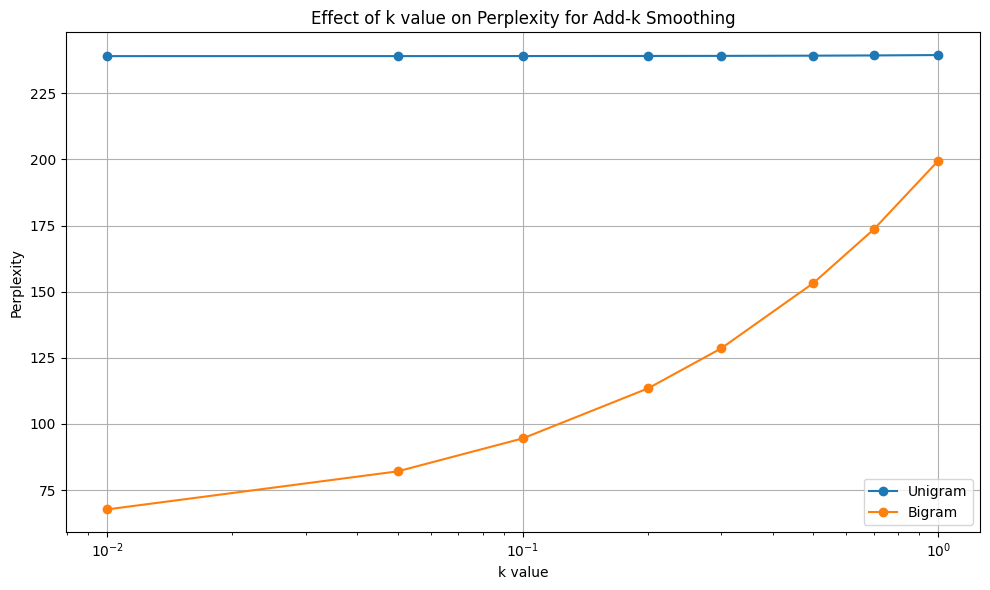

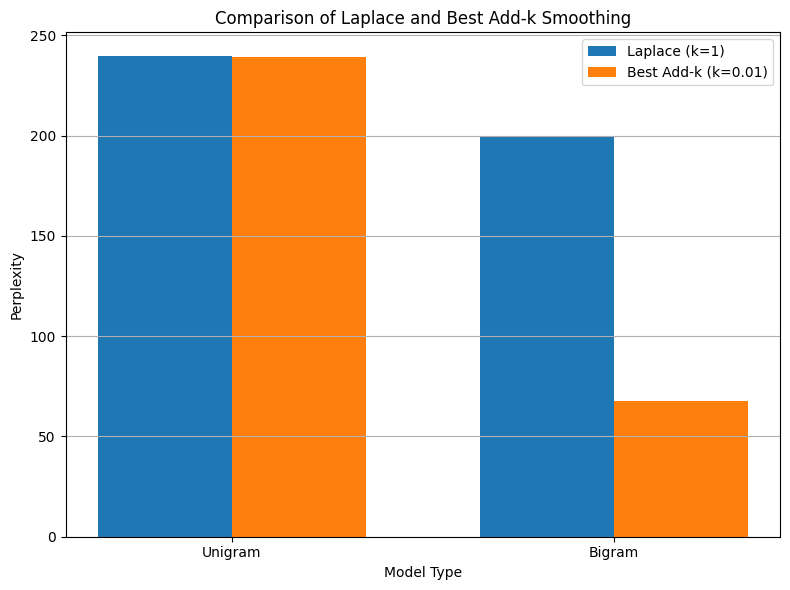

In [23]:
plt.figure(figsize=(10, 6))
plt.plot([float(k) for k in k_values],
         [k_results[f"Add-{k} Unigram"] for k in k_values], 'o-', label='Unigram')
plt.plot([float(k) for k in k_values],
         [k_results[f"Add-{k} Bigram"] for k in k_values], 'o-', label='Bigram')
plt.xlabel('k value')
plt.ylabel('Perplexity')
plt.title('Effect of k value on Perplexity for Add-k Smoothing')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Log scale for better visualization of small k values
plt.tight_layout()
plt.show()

# Visualize comparison
plt.figure(figsize=(8, 6))
models = ['Unigram', 'Bigram']
laplace_perps = [laplace_uni_perp, laplace_bi_perp]
best_k_perps = [best_k_uni_perp, best_k_bi_perp]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, laplace_perps, width, label=f'Laplace (k=1)')
plt.bar(x + width/2, best_k_perps, width, label=f'Best Add-k (k={best_k})')

plt.xlabel('Model Type')
plt.ylabel('Perplexity')
plt.title('Comparison of Laplace and Best Add-k Smoothing')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()